## **Binary Classification with PyTorch**
This notebook implements binary logistic regression for classifying MNIST digits (0s and 1s) using PyTorch. We'll build the model from scratch and implement the training loop manually to understand the underlying concepts.

## 1. Setup and Imports
First, we'll import the required libraries and set up our configuration parameters.

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### 1.1 Configuration and Seed

In [45]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28  # 784 pixels
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 20
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## 2. Data Preparation
We'll create a custom dataset class for handling binary MNIST data (0s and 1s only) and implement the data loading utilities.

In [46]:
class BinaryMNISTDataset(Dataset):
    """
    Custom Dataset to filter MNIST for only digits 0 and 1, and flatten images.
    Digit 1 is relabeled as 1 (Positive Class).
    Digit 0 is relabeled as 0 (Negative Class).
    """
    def __init__(self, data, targets):
        # Flatten the 28x28 images into 784 features
        self.data = data.float().reshape(-1, INPUT_SIZE)
        # Reshape targets to (N, 1) and move to float for BCE loss
        self.targets = targets.float().unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### 2.1 Data Loading Function

In [47]:
def get_binary_dataloaders(batch_size=BATCH_SIZE):
    """Loads MNIST, filters for 0s and 1s, splits, and creates DataLoaders."""
    train_data = datasets.MNIST(
        root='./data', train=True, download=True
    )

    # Filter for digits 0 and 1
    is_binary_mask = (train_data.targets == 0) | (train_data.targets == 1)
    X_full = train_data.data[is_binary_mask]
    Y_full = train_data.targets[is_binary_mask]

    # 1. Convert to float and scale to [0, 1]
    X_full = X_full.float() / 255.0

    # 2. Normalize with the standard MNIST mean and std deviation
    mean = 0.1307
    std = 0.3081
    X_full = (X_full - mean) / std


    # Split into Train/Validation/Test (60% / 20% / 20%)
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(
        X_full, Y_full, test_size=0.2, random_state=SEED, stratify=Y_full
    )

    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_val, Y_train_val, test_size=(0.2/0.8), random_state=SEED, stratify=Y_train_val
    )

    # Create Custom Datasets
    train_dataset = BinaryMNISTDataset(X_train, Y_train)
    val_dataset = BinaryMNISTDataset(X_val, Y_val)
    test_dataset = BinaryMNISTDataset(X_test, Y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## 3. Model, Loss, and Accuracy
Here we implement the Binary Logistic Regression model and define our loss and accuracy functions.

In [48]:
class BinaryLogisticRegression:
    """
    Logistic Regression Model implemented from scratch using pure PyTorch tensors.
    W: (784, 1), b: (1,)
    """
    def __init__(self, input_size):
        # Initialize Weights (W) with small random values and Bias (b) with zeros
        self.W = torch.randn(input_size, 1, device=DEVICE) * 0.01
        self.b = torch.zeros(1, device=DEVICE)
        self.W.requires_grad_(True)
        self.b.requires_grad_(True)

    def forward(self, x):
        # Linear Score (Logit): z = X @ W + b
        linear = torch.matmul(x, self.W) + self.b
        # Sigmoid Activation: y_hat = sigma(z)
        y_pred = torch.sigmoid(linear)
        return y_pred

    def parameters(self):
        return [self.W, self.b]

### 3.1 Loss Function

In [49]:
def custom_binary_cross_entropy(y_pred, y_true):
    # Clip predictions to prevent log(0)
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss.mean()

### 3.2 Accuracy Function

In [50]:
def calculate_binary_accuracy(y_pred, y_true):
    """Calculates accuracy by converting probabilities to class labels (0 or 1)."""
    y_pred_class = (y_pred >= 0.5).float()
    correct = (y_pred_class == y_true).float().sum()
    return (correct / len(y_true)).item()

## 4. Training and Evaluation Functions
Here we implement the training loop and evaluation functions for our model.

In [51]:
def train_model_binary(model, optimizer, train_loader, val_loader, loss_fn, epochs):
    """
    The main training loop using a PyTorch Optimizer.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"Starting training on {DEVICE}...")

    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = 0.0, 0.0

        # --- TRAINING PHASE ---
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            # 1. Forward Pass
            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # 2. Reset gradients
            optimizer.zero_grad()

            # 3. Backward Pass
            loss.backward()

            # 4. Optimizer Step (Gradient Descent Update)
            optimizer.step()

            # Accumulate metrics
            epoch_train_loss += loss.item() * len(X_batch)
            epoch_train_acc += calculate_binary_accuracy(y_pred, y_batch) * len(X_batch)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_acc = epoch_train_acc / len(train_loader.dataset)

        # --- VALIDATION PHASE ---
        epoch_val_loss, epoch_val_acc = 0.0, 0.0
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader:
                X_batch_val, y_batch_val = X_batch_val.to(DEVICE), y_batch_val.to(DEVICE)

                y_pred_val = model.forward(X_batch_val)
                loss_val = loss_fn(y_pred_val, y_batch_val)

                epoch_val_loss += loss_val.item() * len(X_batch_val)
                epoch_val_acc += calculate_binary_accuracy(y_pred_val, y_batch_val) * len(X_batch_val)

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        avg_val_acc = epoch_val_acc / len(val_loader.dataset)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)

        print(f'Epoch {epoch+1:2d}/{epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

### 4.1 Evaluation Function

In [52]:
def evaluate_binary_model(model, test_loader, loss_fn):
    """
    Evaluates final model performance on the Test Set.
    """
    all_preds, all_targets = [], []
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch)

            total_loss += loss.item() * len(X_batch)
            y_pred_class = (y_pred >= 0.5).float()

            all_preds.extend(y_pred_class.cpu().numpy().flatten())
            all_targets.extend(y_batch.cpu().numpy().flatten())

    avg_loss = total_loss / len(test_loader.dataset)
    conf_matrix = confusion_matrix(all_targets, all_preds)
    final_acc = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(all_targets)

    return final_acc, conf_matrix, avg_loss

## 5. Plotting Utilities
Function to visualize training progress.

In [53]:
def plot_metrics(train_metrics, val_metrics, title, ylabel):
    """Generates a plot for tracking convergence."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Training {ylabel}')
    plt.plot(val_metrics, label=f'Validation {ylabel}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

## 6. Model Training and Evaluation


In [54]:
# 1. Load and prepare binary data (0s and 1s only)
train_loader_binary, val_loader_binary, test_loader_binary = get_binary_dataloaders()

In [55]:
# 2. Instantiate the model
model_binary = BinaryLogisticRegression(INPUT_SIZE)

# 3. Instantiate the Optimizer
optimizer = torch.optim.SGD(model_binary.parameters(), lr=LEARNING_RATE)

In [56]:
# 4. Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_binary(
    model=model_binary,
    optimizer=optimizer,
    train_loader=train_loader_binary,
    val_loader=val_loader_binary,
    loss_fn=custom_binary_cross_entropy,
    epochs=NUM_EPOCHS
)

Starting training on cpu...
Epoch  1/20 | Train Loss: 0.0504, Acc: 0.9936 | Val Loss: 0.0190, Acc: 0.9961
Epoch  2/20 | Train Loss: 0.0133, Acc: 0.9980 | Val Loss: 0.0136, Acc: 0.9964
Epoch  3/20 | Train Loss: 0.0097, Acc: 0.9984 | Val Loss: 0.0115, Acc: 0.9964
Epoch  4/20 | Train Loss: 0.0079, Acc: 0.9986 | Val Loss: 0.0104, Acc: 0.9964
Epoch  5/20 | Train Loss: 0.0068, Acc: 0.9987 | Val Loss: 0.0097, Acc: 0.9964
Epoch  6/20 | Train Loss: 0.0061, Acc: 0.9988 | Val Loss: 0.0092, Acc: 0.9964
Epoch  7/20 | Train Loss: 0.0055, Acc: 0.9989 | Val Loss: 0.0089, Acc: 0.9964
Epoch  8/20 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.0087, Acc: 0.9968
Epoch  9/20 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.0085, Acc: 0.9968
Epoch 10/20 | Train Loss: 0.0044, Acc: 0.9991 | Val Loss: 0.0083, Acc: 0.9968
Epoch 11/20 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.0082, Acc: 0.9968
Epoch 12/20 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0080, Acc: 0.9972
Epoch 13/20 | Train Loss: 0.0037, Ac

In [57]:
# 5. Evaluate on the Test Set
test_acc, conf_matrix, test_loss = evaluate_binary_model(
    model=model_binary,
    test_loader=test_loader_binary,
    loss_fn=custom_binary_cross_entropy
)

## 6.1 Final Results

In [71]:
# 6. Output Results and Visualizations
print(f"Final Test Set Results (Binary Classification)")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Final Test Set Results (Binary Classification)
Test Loss: 0.0051
Test Accuracy: 99.84%


## 6.2 Plot Metrics

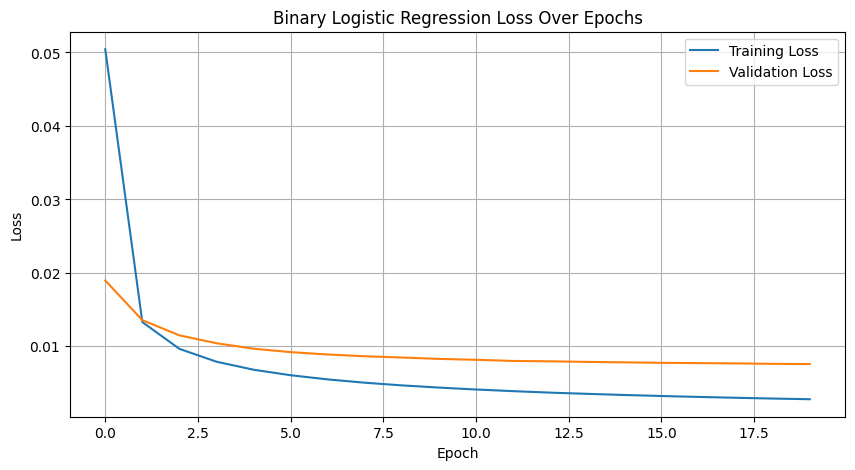

In [59]:
# Plotting Loss Curve
plot_metrics(train_losses, val_losses,
            'Binary Logistic Regression Loss Over Epochs', 'Loss')

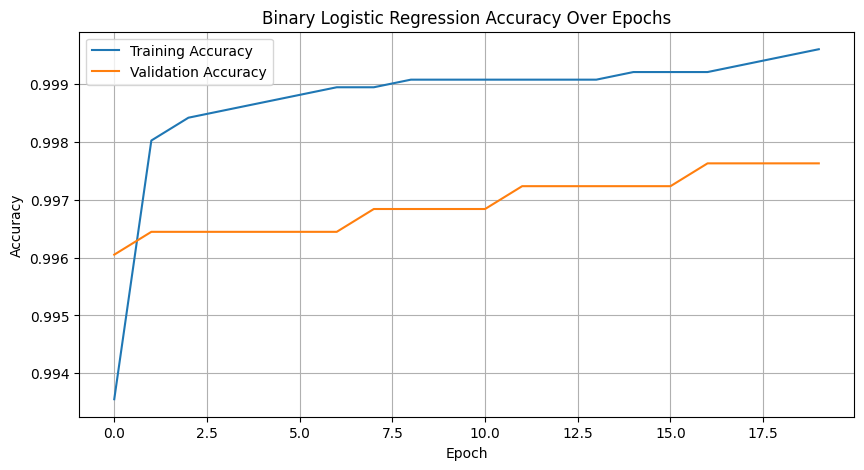

In [60]:
# Plotting Accuracy Curve
plot_metrics(train_accuracies, val_accuracies,
            'Binary Logistic Regression Accuracy Over Epochs', 'Accuracy')

## 6.3 Plotting Confusion Matrix

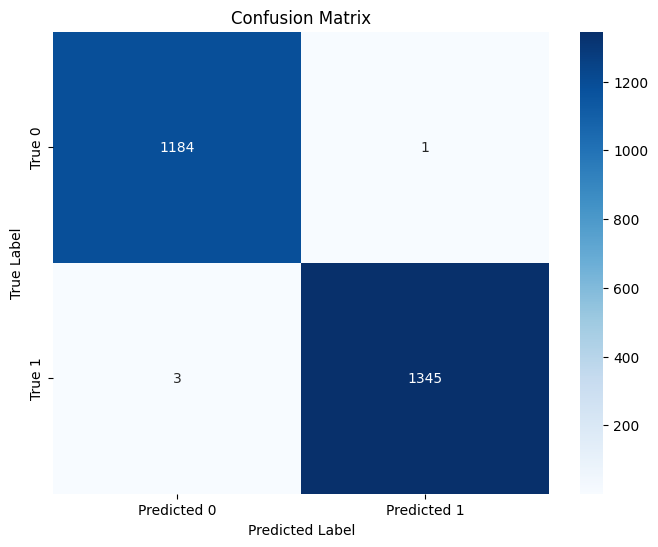

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create the heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,     # Show the numbers inside the squares
            fmt='d',        # Format the numbers as integers
            cmap='Blues',   # Use a blue color scheme
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

# 2. Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 3. Show the plot
plt.show()